In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import joblib
from tqdm import tqdm
import joblib
from sklearn.utils import shuffle


from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table, mcnemar

## Veri Setini Yükleme

In [11]:
TRAIN_DIR ="Training"
TEST_DIR  = "Testing"

labels = ["glioma", "meningioma", "notumor", "pituitary"]
IMAGE_SIZE = 64
SEED = 42

In [12]:
def load_images(directory, image_size):
    X, y = [], []

    for label in labels:
        folder = os.path.join(directory, label)
        if not os.path.exists(folder):
            print(f"{folder} bulunamadı!")
            continue

        for img_name in tqdm(os.listdir(folder), desc=f"Yükleniyor: {label}"):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img = cv2.resize(img, (image_size, image_size))
            img = img / 255.0  # normalize

            X.append(img)
            y.append(labels.index(label))

    X = np.array(X, dtype=np.float32)
    y = np.array(y)

    return shuffle(X, y, random_state=SEED)

In [13]:
print("Training verisi yükleniyor...")
X_train, y_train = load_images(TRAIN_DIR, IMAGE_SIZE)

print("\nTesting verisi yükleniyor...")
X_test, y_test = load_images(TEST_DIR, IMAGE_SIZE)

print("\nYükleme tamamlandı!")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

Training verisi yükleniyor...


Yükleniyor: pituitary: 100%|██████████████████████████████████████████████████████| 1457/1457 [00:04<00:00, 328.23it/s]



Testing verisi yükleniyor...


Yükleniyor: pituitary: 100%|████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 277.82it/s]



Yükleme tamamlandı!
X_train: (5712, 64, 64, 3)
X_test : (1311, 64, 64, 3)


## Flatten İşlemi

In [14]:
print(X_train.shape)
print(y_train.shape)

(5712, 64, 64, 3)
(5712,)


In [15]:
X_train= X_train.reshape(X_train.shape[0], -1)
X_test= X_test.reshape(X_test.shape[0], -1)

In [16]:
print(X_train.shape)
print(y_train.shape)

(5712, 12288)
(5712,)


## Logistic Regression Hold Out

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=5000,
    solver='lbfgs',
    n_jobs=-1
)

In [11]:
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [21]:
y_pred_lr=lr.predict(X_test)
y_prob_lr=lr.predict_proba(X_test)

In [13]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression Accuracy:", round(accuracy_lr, 4))

Logistic Regression Accuracy: 0.894


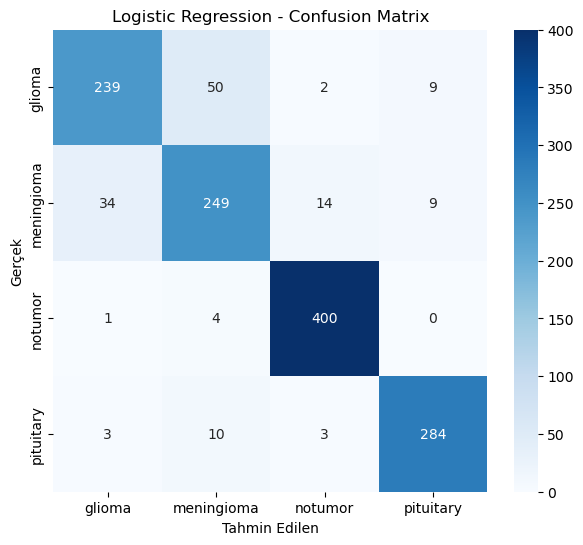

In [14]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

In [18]:
report = classification_report(
    y_test,
    y_pred_lr,
    target_names=labels,
    output_dict=True
)

df = pd.DataFrame(report).T
df = df.iloc[:-3][['precision', 'recall', 'f1-score']]

specificity = []
cm = cm_lr

for i in range(len(labels)):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    spec = TN / (TN + FP)
    specificity.append(spec)

df['specificity'] = specificity
df = df.round(4)

print("Logistic Regression - Performans Tablosu")
print("\nAccuracy:", round(accuracy_lr, 4))
print("-"*45)
print(df)

Logistic Regression - Performans Tablosu

Accuracy: 0.894
---------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.8628  0.7967    0.8284       0.9624
meningioma     0.7955  0.8137    0.8045       0.9363
notumor        0.9547  0.9877    0.9709       0.9790
pituitary      0.9404  0.9467    0.9435       0.9822


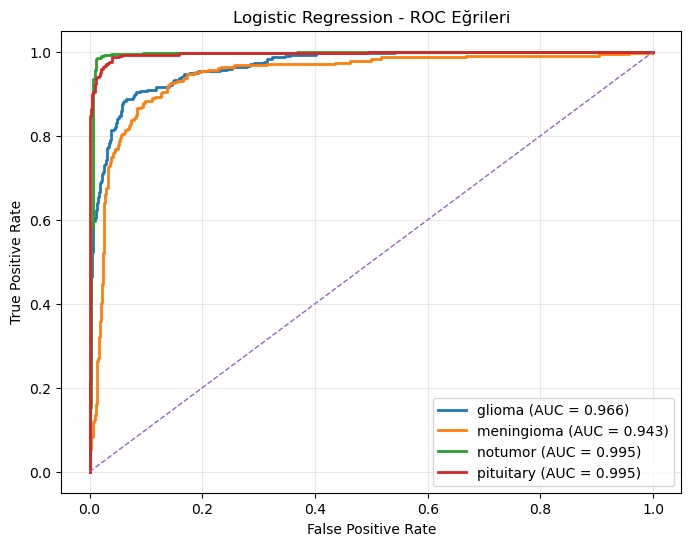

In [23]:
plt.figure(figsize=(8, 6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob_lr[:, i])
    auc_score = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        linewidth=2,
        label=f"{label} (AUC = {auc_score:.3f})"
    )

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression - ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Logistic Regression K-Fold

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
all_true = []
all_pred = []

print("Logistic Regression - k-Fold Sonuçları")
print("-" * 45)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):

    X_train_k, X_val_k = X_train[train_idx], X_train[val_idx]
    y_train_k, y_val_k = y_train[train_idx], y_train[val_idx]

    lr = LogisticRegression(
        max_iter=5000,
        solver="lbfgs",
        n_jobs=-1
    )

    lr.fit(X_train_k, y_train_k)
    y_pred_k = lr.predict(X_val_k)

    # Accuracy
    acc = accuracy_score(y_val_k, y_pred_k)
    fold_accuracies.append(acc)

    all_true.extend(y_val_k)
    all_pred.extend(y_pred_k)

    print(f"Fold {fold}: Accuracy = {acc:.4f}")

print("-" * 45)
print(f"Ortalama Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Std Sapma        : {np.std(fold_accuracies):.4f}")

Logistic Regression - k-Fold Sonuçları
---------------------------------------------
Fold 1: Accuracy = 0.8425
Fold 2: Accuracy = 0.8478
Fold 3: Accuracy = 0.8608
Fold 4: Accuracy = 0.8459
Fold 5: Accuracy = 0.8669
---------------------------------------------
Ortalama Accuracy: 0.8528
Std Sapma        : 0.0094


In [28]:
metrics = {
    "precision": [],
    "recall": [],
    "f1-score": [],
    "specificity": []
}

for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    precision = TP / (TP + FP)
    recall    = TP / (TP + FN)
    f1        = 2 * precision * recall / (precision + recall)
    specificity = TN / (TN + FP)

    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1-score"].append(f1)
    metrics["specificity"].append(specificity)

df_kfold_metrics = pd.DataFrame(metrics, index=labels).round(4)

print("Logistic Regression - k-Fold Performans Tablosu")
print(f"Ortalama Accuracy: {np.mean(fold_accuracies):.4f}")
print("-" * 45)
print(df_kfold_metrics)

Logistic Regression - k-Fold Performans Tablosu
---------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.8092  0.8282    0.8186       0.9412
meningioma     0.7472  0.6998    0.7227       0.9275
notumor        0.9363  0.9116    0.9238       0.9760
pituitary      0.8925  0.9513    0.9209       0.9608


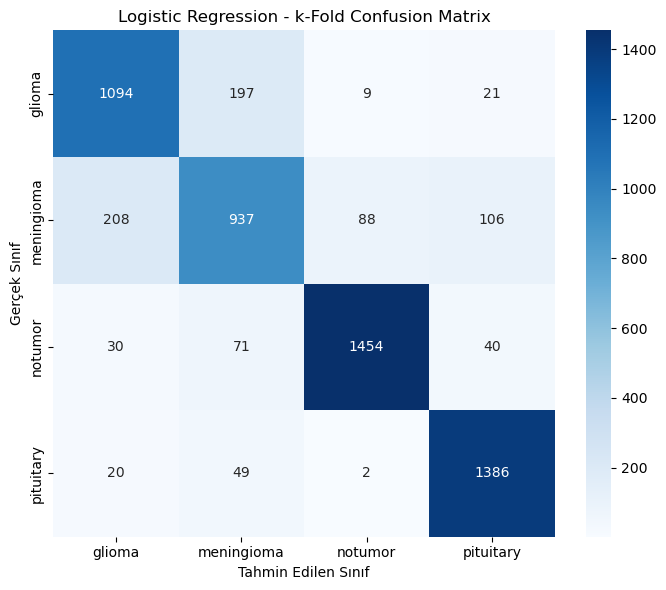

In [30]:
cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(7, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Logistic Regression - k-Fold Confusion Matrix")
plt.tight_layout()
plt.show()

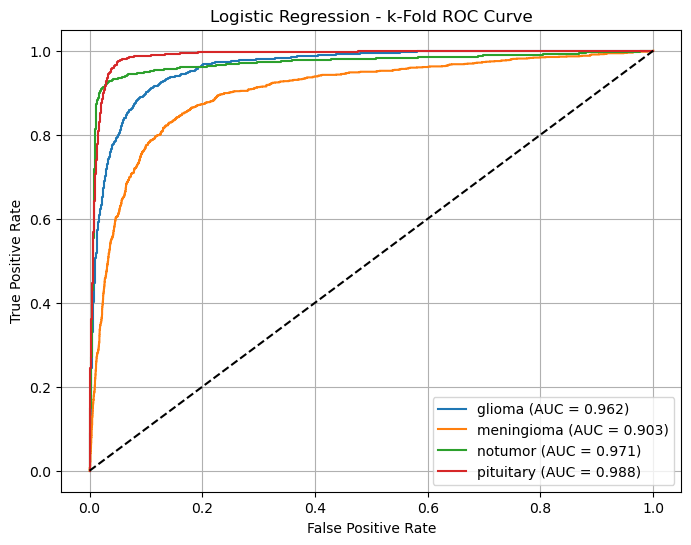

In [35]:

class_names = ["glioma", "meningioma", "notumor", "pituitary"]
n_classes = len(class_names)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_true_all = []
y_prob_all = []

for train_idx, val_idx in skf.split(X_train, y_train):

    X_train_k, X_val_k = X_train[train_idx], X_train[val_idx]
    y_train_k, y_val_k = y_train[train_idx], y_train[val_idx]

    lr = LogisticRegression(
        max_iter=5000,
        solver="lbfgs",
        n_jobs=-1
    )

    lr.fit(X_train_k, y_train_k)

    y_prob = lr.predict_proba(X_val_k)

    y_true_all.append(y_val_k)
    y_prob_all.append(y_prob)

y_true_all = np.concatenate(y_true_all)
y_prob_all = np.concatenate(y_prob_all)


y_true_bin = label_binarize(y_true_all, classes=range(n_classes))

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob_all[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression - k-Fold ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## KNN HOLD OUT

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_knn = scaler.fit_transform(X_train)
X_test_knn  = scaler.transform(X_test)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5,
    weights="distance",
    metric="euclidean"
)

knn.fit(X_train_knn, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'euclidean'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [24]:
y_pred_knn=knn.predict(X_test_knn)
y_prob_knn=knn.predict_proba(X_test_knn)

In [25]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)

cm_knn= confusion_matrix(y_test, y_pred_knn)

metrics = []

for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    precision = TP / (TP + FP)
    recall    = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1 = 2 * (precision * recall) / (precision + recall)

    metrics.append([
        precision,
        recall,
        f1,
        specificity
    ])

metrics_df = pd.DataFrame(
    metrics,
    index=labels,
    columns=["precision", "recall", "f1-score", "specificity"]
)

metrics_df = metrics_df.round(4)

print("KNN - Hold-Out Performans Tablosu")
print("-" * 45)
print(metrics_df)

print(f"\nGenel Doğruluk (Accuracy): {accuracy_knn:.4f}")

NameError: name 'cm' is not defined

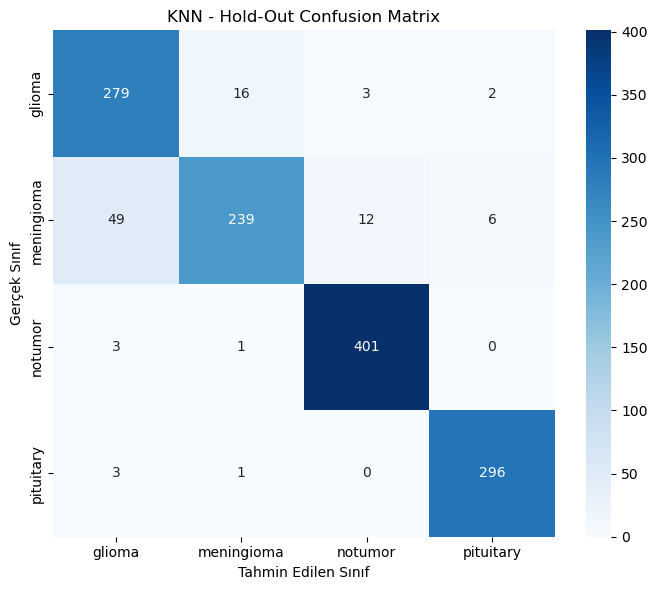

In [16]:
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_knn,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("KNN - Hold-Out Confusion Matrix")
plt.tight_layout()
plt.show()

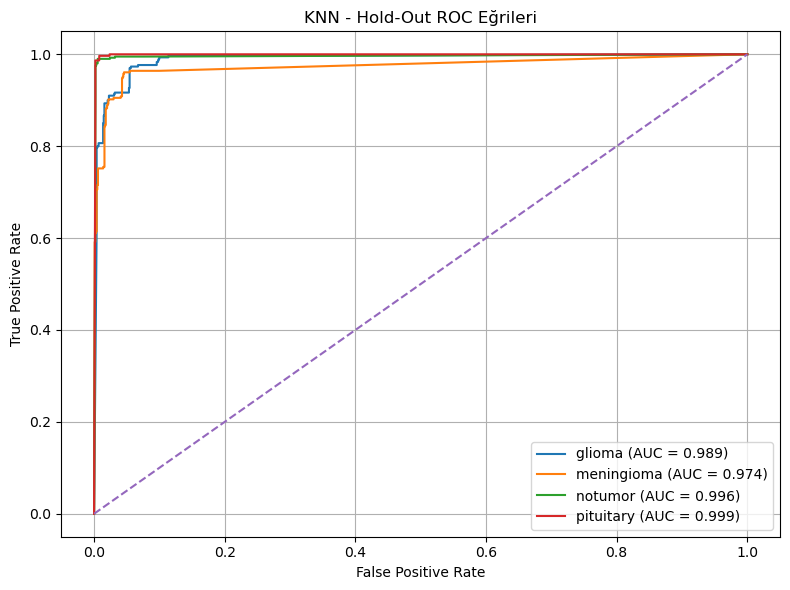

In [17]:
plt.figure(figsize=(8, 6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob_knn[:, i])
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN - Hold-Out ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## KNN K-FOLD

In [8]:
scaler = StandardScaler()

X_train_knn = scaler.fit_transform(X_train) 
X_test_knn  = scaler.transform(X_test)


joblib.dump(scaler, "scaler2.pkl")


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies_knn = []
best_acc = 0.0
best_knn_model = None


for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_knn, y_train), 1):

    X_train_k, X_val_k = X_train_knn[train_idx], X_train_knn[val_idx]
    y_train_k, y_val_k = y_train[train_idx], y_train[val_idx]

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_k, y_train_k)
    
    y_pred_fold = knn.predict(X_val_k)
    acc = accuracy_score(y_val_k, y_pred_fold)
    
    fold_accuracies_knn.append(acc)

    if acc > best_acc:
        best_acc = acc
        best_knn_model = knn

    print(f"Fold {fold}: Accuracy = {acc:.4f}")

joblib.dump(best_knn_model, "knn_model2.pkl") 

print(f"\nOrtalama Accuracy: {np.mean(fold_accuracies_knn):.4f}")
print("En iyi model 'knn_model2.pkl' olarak kaydedildi.")

Fold 1: Accuracy = 0.8574
Fold 2: Accuracy = 0.8653
Fold 3: Accuracy = 0.8441
Fold 4: Accuracy = 0.8494
Fold 5: Accuracy = 0.8494

Ortalama Accuracy: 0.8531
En iyi model 'knn_model2.pkl' olarak kaydedildi.


In [20]:
cm = confusion_matrix(y_test,y_pred_knn)

rows = []

for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    precision = TP / (TP + FP)
    recall    = TP / (TP + FN)
    f1        = 2 * precision * recall / (precision + recall)
    specificity = TN / (TN + FP)

    rows.append([
        precision,
        recall,
        f1,
        specificity
    ])

metrics_table_knn = pd.DataFrame(
    rows,
    index=labels,
    columns=["precision", "recall", "f1-score", "specificity"]
)

accuracy_knn = accuracy_score(y_test, y_pred_knn)

print("KNN - K-Fold Performans Tablosu")
print("-" * 45)
print(metrics_table_knn.round(4))
print("\nGenel Doğruluk (Accuracy): {:.4f}".format(accuracy_knn))

KNN - Hold-Out Performans Tablosu
---------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.8353  0.9300    0.8801       0.9456
meningioma     0.9300  0.7810    0.8490       0.9821
notumor        0.9639  0.9901    0.9769       0.9834
pituitary      0.9737  0.9867    0.9801       0.9921

Genel Doğruluk (Accuracy): 0.9268


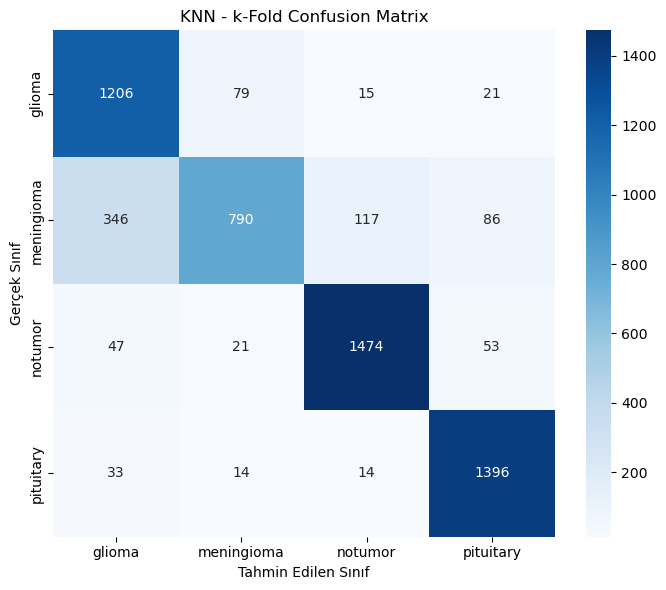

In [21]:
all_true = []
all_pred = []

for train_idx, val_idx in skf.split(X_train, y_train):

    X_train_k = X_train[train_idx]
    X_val_k   = X_train[val_idx]

    y_train_k = y_train[train_idx]
    y_val_k   = y_train[val_idx]

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_k, y_train_k)

    y_pred_k = knn.predict(X_val_k)

    all_true.extend(y_val_k)
    all_pred.extend(y_pred_k)

cm_knn_kfold = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_knn_kfold,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("KNN - k-Fold Confusion Matrix")
plt.tight_layout()
plt.show()

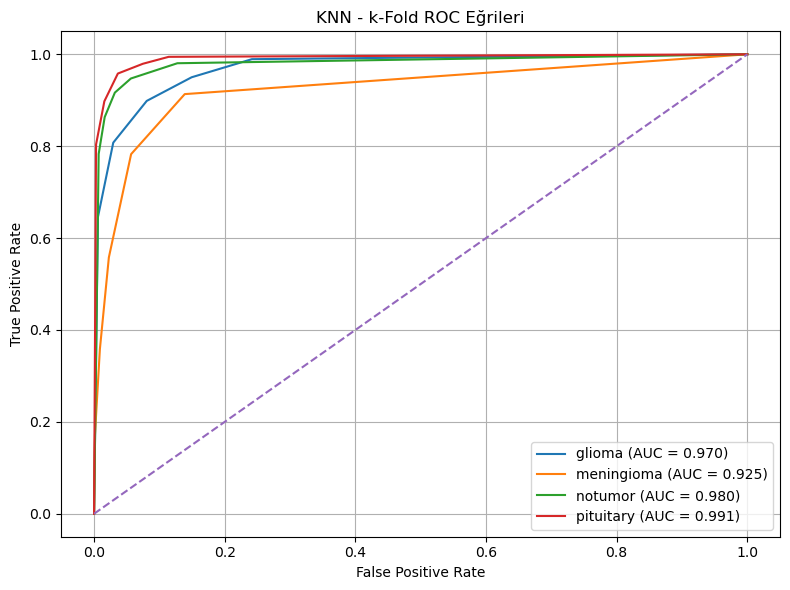

In [23]:
all_true = np.array(all_true)
all_prob = []

for train_idx, val_idx in skf.split(X_train, y_train):

    X_train_k = X_train[train_idx]
    X_val_k   = X_train[val_idx]

    y_train_k = y_train[train_idx]

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_k, y_train_k)

    probs = knn.predict_proba(X_val_k)
    all_prob.append(probs)

all_prob = np.vstack(all_prob)

plt.figure(figsize=(8, 6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(all_true == i, all_prob[:, i])
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN - k-Fold ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## SVM HOLD OUT

In [24]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    random_state=42
)

svm.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [25]:
y_pred_svm=svm.predict(X_test)
y_prob_svm=svm.predict_proba(X_test)

In [26]:
cm = confusion_matrix(y_test, y_pred_svm)

rows = []

for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    precision = TP / (TP + FP)
    recall    = TP / (TP + FN)
    f1        = 2 * precision * recall / (precision + recall)
    specificity = TN / (TN + FP)

    rows.append([precision, recall, f1, specificity])

metrics_table_svm = pd.DataFrame(
    rows,
    index=labels,
    columns=["precision", "recall", "f1-score", "specificity"]
)

accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("SVM - Hold-Out Performans Tablosu")
print("-" * 45)
print(metrics_table_svm.round(4))
print("\nGenel Doğruluk (Accuracy): {:.4f}".format(accuracy_svm))

SVM - Hold-Out Performans Tablosu
---------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.8576  0.8233    0.8401       0.9594
meningioma     0.8166  0.7712    0.7933       0.9473
notumor        0.9402  0.9704    0.9550       0.9724
pituitary      0.9241  0.9733    0.9481       0.9763

Genel Doğruluk (Accuracy): 0.8909


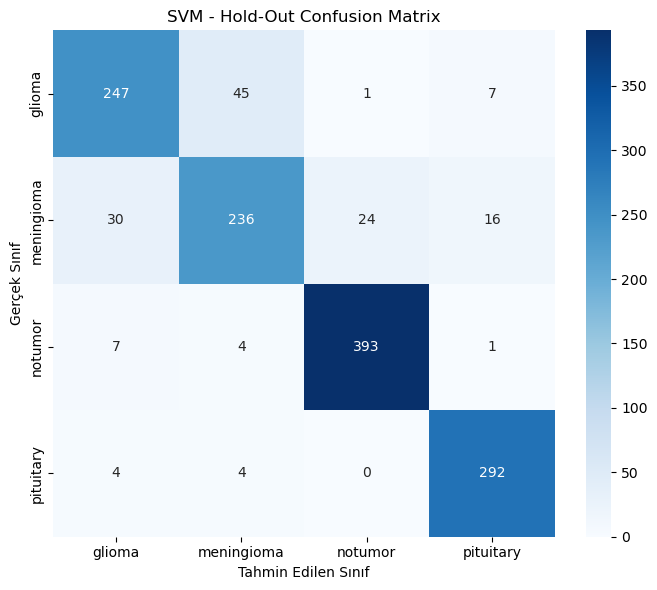

In [27]:
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("SVM - Hold-Out Confusion Matrix")
plt.tight_layout()
plt.show()

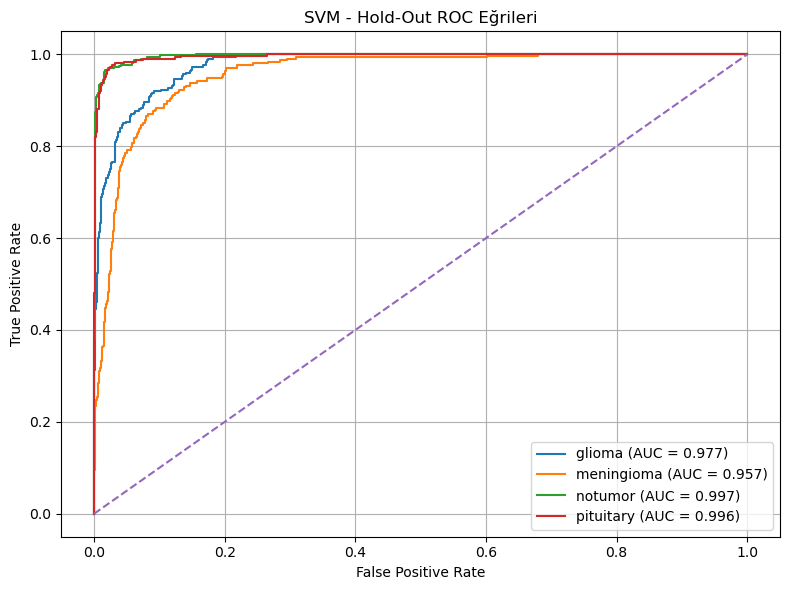

In [28]:
plt.figure(figsize=(8, 6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob_svm[:, i])
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM - Hold-Out ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## SVM K-FOLD

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

all_true = []
all_pred = []
all_prob = []


for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):

    X_train_k = X_train[train_idx]
    X_val_k   = X_train[val_idx]

    y_train_k = y_train[train_idx]
    y_val_k   = y_train[val_idx]

    svm = SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42
    )

    svm.fit(X_train_k, y_train_k)

    y_pred_k = svm.predict(X_val_k)
    y_prob_k = svm.predict_proba(X_val_k)

    acc = accuracy_score(y_val_k, y_pred_k)
    fold_accuracies.append(acc)

    all_true.extend(y_val_k)
    all_pred.extend(y_pred_k)
    all_prob.extend(y_prob_k)

    print(f"Fold {fold}: Accuracy = {acc:.4f}")

Fold 1: Accuracy = 0.8836
Fold 2: Accuracy = 0.8644
Fold 3: Accuracy = 0.8914
Fold 4: Accuracy = 0.8835
Fold 5: Accuracy = 0.8687


In [14]:
rows = []

for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    precision = TP / (TP + FP)
    recall    = TP / (TP + FN)
    f1        = 2 * precision * recall / (precision + recall)
    specificity = TN / (TN + FP)

    rows.append([precision, recall, f1, specificity])

metrics_table_svm_kfold = pd.DataFrame(
    rows,
    index=labels,
    columns=["precision", "recall", "f1-score", "specificity"]
)

print("SVM - k-Fold Performans Tablosu")
print("-" * 45)
print(metrics_table_svm_kfold.round(4))

SVM - k-Fold Performans Tablosu
---------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.8587  0.8327    0.8455       0.9588
meningioma     0.7902  0.7595    0.7746       0.9383
notumor        0.9380  0.9386    0.9383       0.9760
pituitary      0.9063  0.9629    0.9338       0.9659


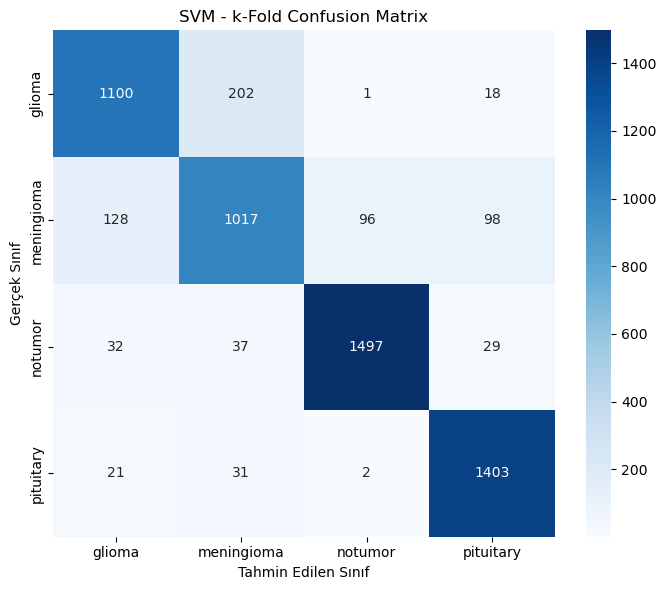

In [13]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("SVM - k-Fold Confusion Matrix")
plt.tight_layout()
plt.show()

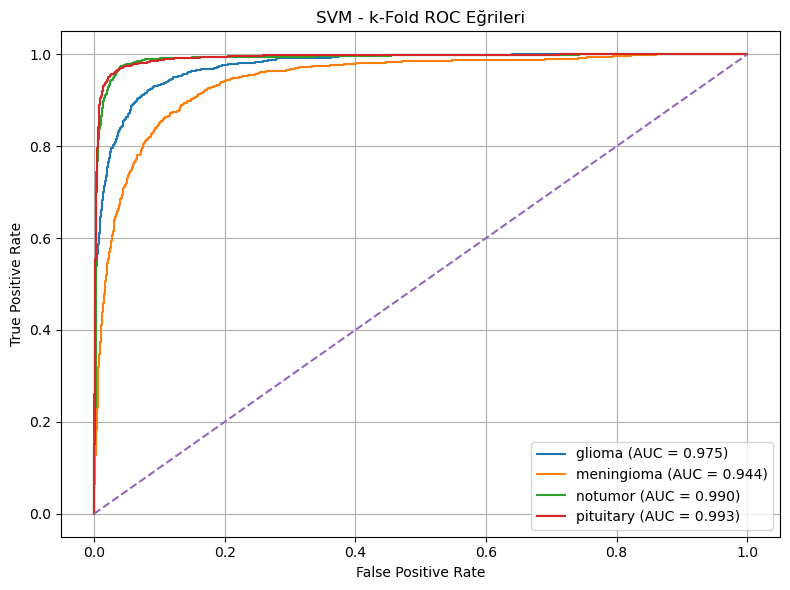

In [15]:
all_prob = np.array(all_prob)
all_true = np.array(all_true)

plt.figure(figsize=(8, 6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(all_true == i, all_prob[:, i])
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM - k-Fold ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Naive Bayes Hold Out

In [16]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [29]:
y_pred_nb=nb.predict(X_test)
y_prob_nb=nb.predict_proba(X_test)

In [25]:
acc_nb = accuracy_score(y_test, y_pred_nb)

report = classification_report(
    y_test,
    y_pred_nb,
    target_names=labels,
    output_dict=True
)

cm = cm_nb
specificity = {}

for i, label in enumerate(labels):
    TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    FP = cm[:, i].sum() - cm[i, i]
    specificity[label] = TN / (TN + FP)

table = pd.DataFrame({
    "precision": [report[l]["precision"] for l in labels],
    "recall":    [report[l]["recall"] for l in labels],
    "f1-score":  [report[l]["f1-score"] for l in labels],
    "specificity": [specificity[l] for l in labels]
}, index=labels)

print("Naive Bayes - Hold-Out Performans Tablosu")
print("-"*45)
print(table.round(4))

print(f"\nGenel Doğruluk (Accuracy): {acc_nb:.4f}")

Naive Bayes - Hold-Out Performans Tablosu
---------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.4876  0.9167    0.6366       0.7141
meningioma     0.2330  0.1340    0.1701       0.8657
notumor        0.6930  0.5407    0.6075       0.8929
pituitary      0.7765  0.6600    0.7135       0.9436

Genel Doğruluk (Accuracy): 0.5591


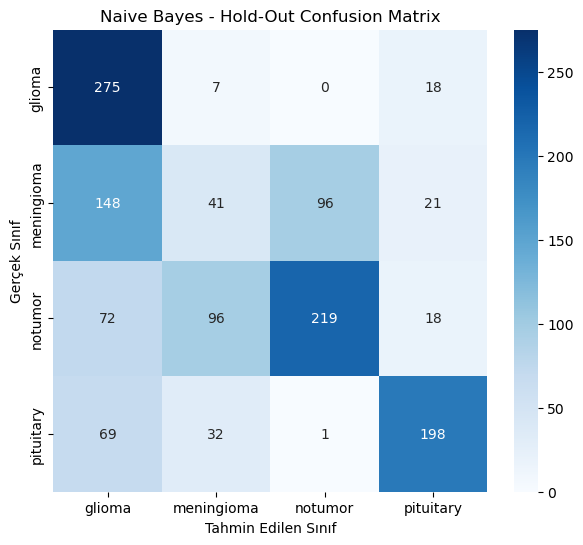

In [27]:
from sklearn.metrics import confusion_matrix

cm_nb=confusion_matrix(y_test,y_pred_nb)


labels = ["glioma", "meningioma", "notumor", "pituitary"]

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Naive Bayes - Hold-Out Confusion Matrix")
plt.show()

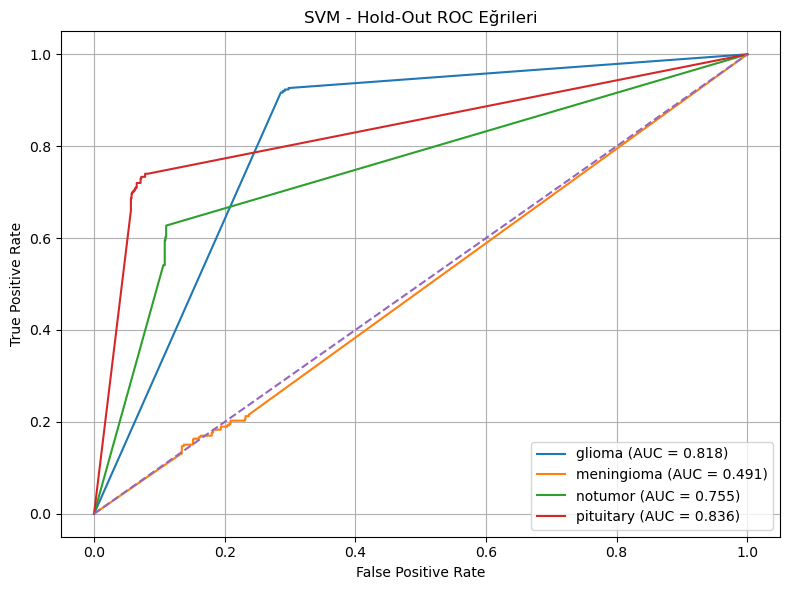

In [34]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob_nb[:, i])
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes - Hold-Out ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## Naive Bayes K-Fold

In [35]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

print("Naive Bayes - k-Fold Sonuçları")
print("-" * 45)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):

    X_train_k = X_train[train_idx]
    X_val_k   = X_train[val_idx]

    y_train_k = y_train[train_idx]
    y_val_k   = y_train[val_idx]

    nb = GaussianNB()
    nb.fit(X_train_k, y_train_k)

    y_pred_k = nb.predict(X_val_k)
    acc = accuracy_score(y_val_k, y_pred_k)
    fold_accuracies.append(acc)

    print(f"Fold {fold}: Accuracy = {acc:.4f}")

print("-" * 45)
print(f"Ortalama Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Std Sapma: {np.std(fold_accuracies):.4f}")

Naive Bayes - k-Fold Sonuçları
---------------------------------------------
Fold 1: Accuracy = 0.6089
Fold 2: Accuracy = 0.5923
Fold 3: Accuracy = 0.6103
Fold 4: Accuracy = 0.6226
Fold 5: Accuracy = 0.6287
---------------------------------------------
Ortalama Accuracy: 0.6126
Std Sapma: 0.0126


In [36]:
all_true = []
all_pred = []

for train_idx, val_idx in skf.split(X_train, y_train):

    X_train_k = X_train[train_idx]
    X_val_k   = X_train[val_idx]

    y_train_k = y_train[train_idx]
    y_val_k   = y_train[val_idx]

    nb = GaussianNB()
    nb.fit(X_train_k, y_train_k)

    y_pred_k = nb.predict(X_val_k)

    all_true.extend(y_val_k)
    all_pred.extend(y_pred_k)

cm_nb_kfold = confusion_matrix(all_true, all_pred)

In [38]:
report = classification_report(
    all_true,
    all_pred,
    target_names=labels,
    output_dict=True
)

specificity = {}
cm = cm_nb_kfold

for i, label in enumerate(labels):
    TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    FP = cm[:, i].sum() - cm[i, i]
    specificity[label] = TN / (TN + FP)

table_nb_kfold = pd.DataFrame({
    "precision":   [report[l]["precision"] for l in labels],
    "recall":      [report[l]["recall"] for l in labels],
    "f1-score":    [report[l]["f1-score"] for l in labels],
    "specificity": [specificity[l] for l in labels]
}, index=labels)

print("Naive Bayes - k-Fold Performans Tablosu")
print("-"*45)
print(table_nb_kfold.round(4))

print(f"\nGenel Doğruluk (Accuracy): {np.mean(fold_accuracies):.4f}")

Naive Bayes - k-Fold Performans Tablosu
---------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.4820  0.9099    0.6301       0.7058
meningioma     0.3517  0.2196    0.2703       0.8761
notumor        0.8852  0.5799    0.7008       0.9709
pituitary      0.8063  0.7399    0.7717       0.9391

Genel Doğruluk (Accuracy): 0.6126


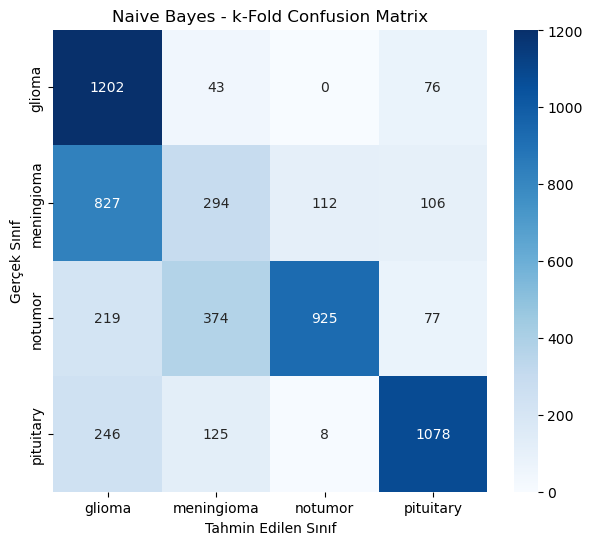

In [37]:
labels = ["glioma", "meningioma", "notumor", "pituitary"]

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_nb_kfold,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Naive Bayes - k-Fold Confusion Matrix")
plt.show()

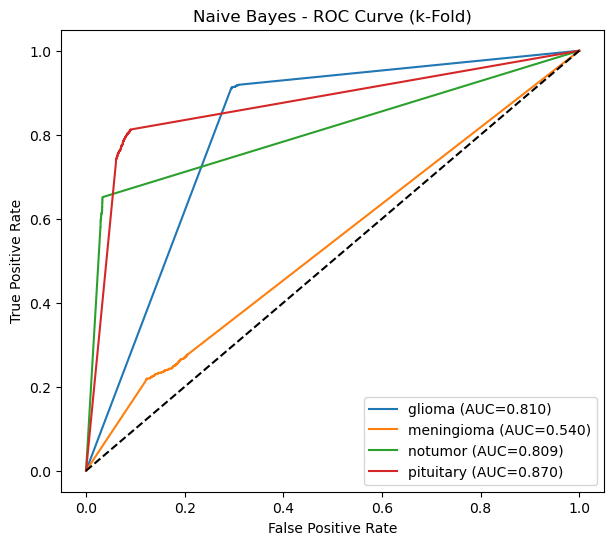

In [42]:
plt.figure(figsize=(7,6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(all_true == i, all_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes - ROC Curve (k-Fold)")
plt.legend()
plt.show()

## Decision Tree Hold Out

In [43]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=None
)

In [44]:
dt.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [51]:
y_pred_dt=dt.predict(X_test)
y_prob_dt=dt.predict_proba(X_test)

In [52]:
acc = accuracy_score(y_test,y_pred_dt)


labels = ["glioma", "meningioma", "notumor", "pituitary"]

cm_dt = confusion_matrix(y_test, y_pred_dt)

report = classification_report(
    y_test,
    y_pred_dt,
    target_names=labels,
    output_dict=True
)

specificity = {}

for i, label in enumerate(labels):
    TN = cm_dt.sum() - (cm_dt[i, :].sum() + cm_dt[:, i].sum() - cm_dt[i, i])
    FP = cm_dt[:, i].sum() - cm_dt[i, i]
    specificity[label] = TN / (TN + FP)

table_dt = pd.DataFrame({
    "precision":   [report[l]["precision"] for l in labels],
    "recall":      [report[l]["recall"] for l in labels],
    "f1-score":    [report[l]["f1-score"] for l in labels],
    "specificity": [specificity[l] for l in labels]
}, index=labels)

print("\nDecision Tree - Hold-Out Performans Tablosu")
print("-"*45)
print(table_dt.round(4))


Decision Tree - Hold-Out Performans Tablosu
---------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.8906  0.7867    0.8354       0.9713
meningioma     0.7608  0.8627    0.8086       0.9174
notumor        0.9424  0.9704    0.9562       0.9735
pituitary      0.9149  0.8600    0.8866       0.9763


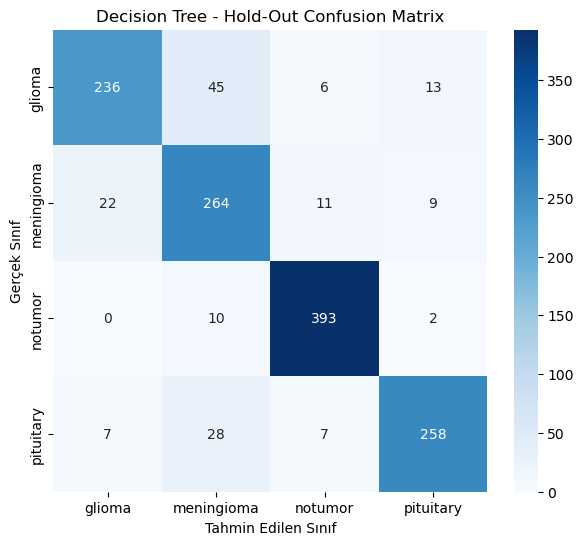

In [53]:
plt.figure(figsize=(7,6))
sns.heatmap(
    cm_dt,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Decision Tree - Hold-Out Confusion Matrix")
plt.show()

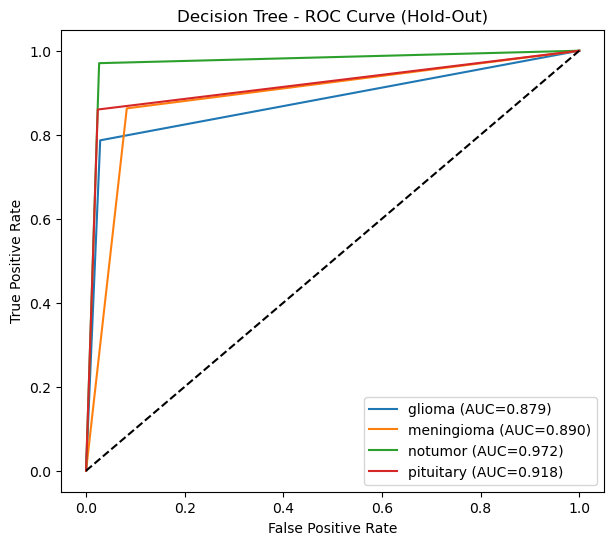

In [54]:
plt.figure(figsize=(7,6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob_dt[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree - ROC Curve (Hold-Out)")
plt.legend()
plt.show()

## Decision Tree K-Fold

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies_dt = []

print("Decision Tree - k-Fold Sonuçları")
print("-"*45)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):

    X_train_k = X_train[train_idx]
    X_val_k   = X_train[val_idx]

    y_train_k = y_train[train_idx]
    y_val_k   = y_train[val_idx]

    dt = DecisionTreeClassifier(
        random_state=42
    )

    dt.fit(X_train_k, y_train_k)
    y_pred_k = dt.predict(X_val_k)

    acc = accuracy_score(y_val_k, y_pred_k)
    fold_accuracies_dt.append(acc)

    print(f"Fold {fold}: Accuracy = {acc:.4f}")

print("-"*45)
print(f"Ortalama Accuracy: {np.mean(fold_accuracies_dt):.4f}")
print(f"Std Sapma: {np.std(fold_accuracies_dt):.4f}")

Decision Tree - k-Fold Sonuçları
---------------------------------------------
Fold 1: Accuracy = 0.8486
Fold 2: Accuracy = 0.8338
Fold 3: Accuracy = 0.8389
Fold 4: Accuracy = 0.8511
Fold 5: Accuracy = 0.8336
---------------------------------------------
Ortalama Accuracy: 0.8412
Std Sapma: 0.0074


In [24]:
report = classification_report(
    all_true_dt,
    all_pred_dt,
    target_names=labels,
    output_dict=True
)

specificity = {}

for i, label in enumerate(labels):
    TN = cm_dt_kfold.sum() - (cm_dt_kfold[i, :].sum() + cm_dt_kfold[:, i].sum() - cm_dt_kfold[i, i])
    FP = cm_dt_kfold[:, i].sum() - cm_dt_kfold[i, i]
    specificity[label] = TN / (TN + FP)

table_dt_kfold = pd.DataFrame({
    "precision":   [report[l]["precision"] for l in labels],
    "recall":      [report[l]["recall"] for l in labels],
    "f1-score":    [report[l]["f1-score"] for l in labels],
    "specificity": [specificity[l] for l in labels]
}, index=labels)

print("\nDecision Tree - k-Fold Performans Tablosu")
print("Accuarcy: ",acc)
print("-"*50)
print(table_dt_kfold.round(4))


Decision Tree - k-Fold Performans Tablosu
Accuarcy:  0.8336252189141856
--------------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.8597  0.8584    0.8591       0.9579
meningioma     0.7258  0.7394    0.7325       0.9145
notumor        0.9025  0.8821    0.8922       0.9631
pituitary      0.8667  0.8744    0.8705       0.9539


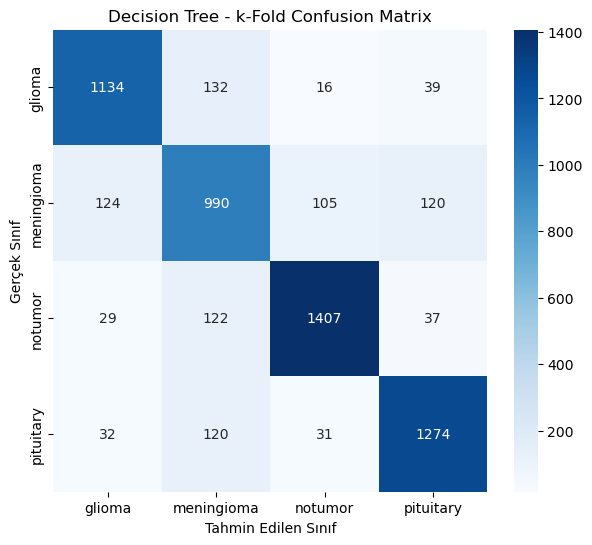

In [12]:
all_true_dt = []
all_pred_dt = []

for train_idx, val_idx in skf.split(X_train, y_train):

    X_train_k = X_train[train_idx]
    X_val_k   = X_train[val_idx]

    y_train_k = y_train[train_idx]
    y_val_k   = y_train[val_idx]

    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train_k, y_train_k)

    y_pred_k = dt.predict(X_val_k)

    all_true_dt.extend(y_val_k)
    all_pred_dt.extend(y_pred_k)

cm_dt_kfold = confusion_matrix(all_true_dt, all_pred_dt)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_dt_kfold,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Decision Tree - k-Fold Confusion Matrix")
plt.show()

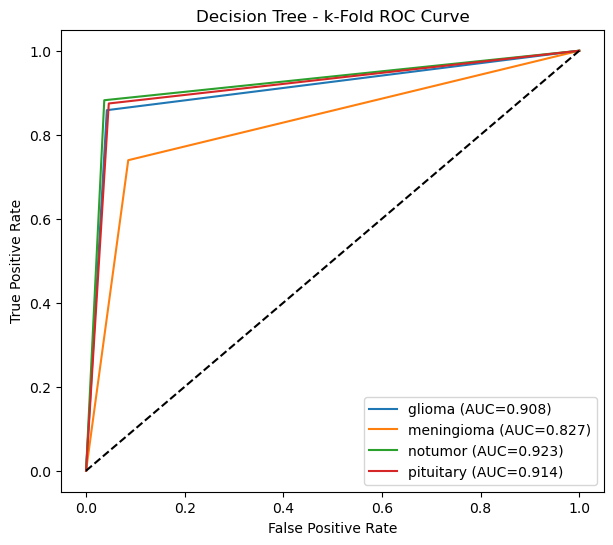

In [14]:
plt.figure(figsize=(7,6))

all_true_dt = np.array(all_true_dt)
all_pred_prob_dt = []

for train_idx, val_idx in skf.split(X_train, y_train):

    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train[train_idx], y_train[train_idx])

    probs = dt.predict_proba(X_train[val_idx])
    all_pred_prob_dt.append(probs)

all_pred_prob_dt = np.vstack(all_pred_prob_dt)

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(all_true_dt == i, all_pred_prob_dt[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree - k-Fold ROC Curve")
plt.legend()
plt.show()

## Ensemble Learning

## Random Forest Hold Out

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

In [14]:
rf.fit(X_train,y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
y_pred_rf=rf.predict(X_test)
y_prob_rf=rf.predict_proba(X_test)

In [18]:
accuarcy_rf=accuracy_score(y_test,y_pred_rf)

report = classification_report(
    y_test,
    y_pred_rf,
    target_names=labels,
    output_dict=True
)

specificity = {}

for i, label in enumerate(labels):
    TN = cm_rf.sum() - (cm_rf[i, :].sum() + cm_rf[:, i].sum() - cm_rf[i, i])
    FP = cm_rf[:, i].sum() - cm_rf[i, i]
    specificity[label] = TN / (TN + FP)

rf_table = pd.DataFrame({
    "precision":   [report[l]["precision"] for l in labels],
    "recall":      [report[l]["recall"] for l in labels],
    "f1-score":    [report[l]["f1-score"] for l in labels],
    "specificity": [specificity[l] for l in labels]
}, index=labels)

print("\nRandom Forest - Hold-Out Performans Tablosu")
print("Accuarcy: ",accuarcy_rf)
print("-"*50)
print(rf_table.round(4))


Random Forest - Hold-Out Performans Tablosu
Accuarcy:  0.9336384439359268
--------------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.9724  0.8233    0.8917       0.9931
meningioma     0.8434  0.9150    0.8777       0.9483
notumor        0.9783  1.0000    0.9890       0.9901
pituitary      0.9389  0.9733    0.9558       0.9812


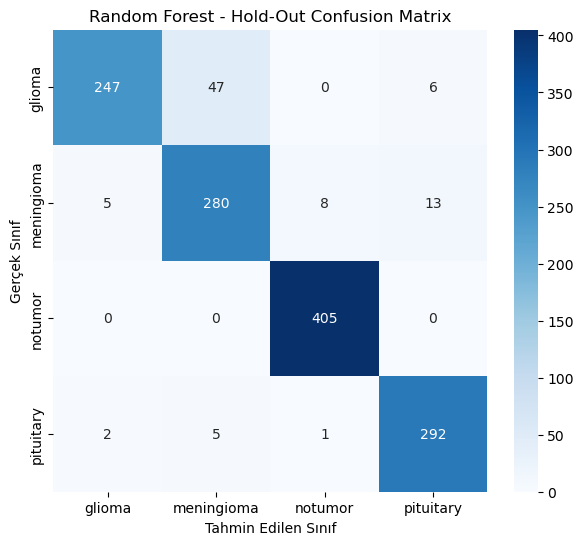

In [17]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Random Forest - Hold-Out Confusion Matrix")
plt.show()

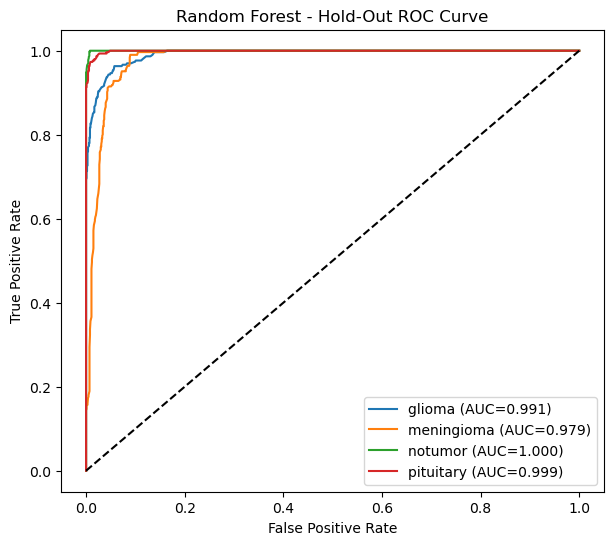

In [26]:
plt.figure(figsize=(7,6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob_rf[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - Hold-Out ROC Curve")
plt.legend()
plt.show()    

## Random Forest K-Fold

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
best_acc = 0.0
best_rf_model = None

print("Random Forest - 5-Fold Eğitim Başlatılıyor...")
print("-" * 45)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_train_k, X_val_k = X_train[train_idx], X_train[val_idx]
    y_train_k, y_val_k = y_train[train_idx], y_train[val_idx]

    rf = RandomForestClassifier(
        n_estimators=200,   
        random_state=42,      
        n_jobs=-1,        
        class_weight='balanced'
    )


    rf.fit(X_train_k, y_train_k)
    

    y_pred = rf.predict(X_val_k)
    acc = accuracy_score(y_val_k, y_pred)
    
    fold_accuracies.append(acc)


    if acc > best_acc:
        best_acc = acc
        best_rf_model = rf

    print(f"Fold {fold}: Başarı Oranı (Accuracy) = {acc:.4f}")

print("-" * 45)
print(f"Ortalama Başarı: {np.mean(fold_accuracies):.4f}")
print(f"En İyi Fold Başarısı: {best_acc:.4f}")


joblib.dump(best_rf_model, "rf_model.pkl")

print("\nİşlem Tamamlandı: 'rf_model.pkl' başarıyla kaydedildi.")

Random Forest - 5-Fold Eğitim Başlatılıyor...
---------------------------------------------
Fold 1: Başarı Oranı (Accuracy) = 0.9379
Fold 2: Başarı Oranı (Accuracy) = 0.9064
Fold 3: Başarı Oranı (Accuracy) = 0.9378
Fold 4: Başarı Oranı (Accuracy) = 0.9264
Fold 5: Başarı Oranı (Accuracy) = 0.9168
---------------------------------------------
Ortalama Başarı: 0.9251
En İyi Fold Başarısı: 0.9379

İşlem Tamamlandı: 'rf_model.pkl' başarıyla kaydedildi.


In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
all_y_true_kfold = [] 
all_y_pred_rf_kfold = []

print("Random Forest - k-Fold Sonuçları")
print("-"*45)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):

    X_train_k = X_train[train_idx]
    X_val_k   = X_train[val_idx]
    y_train_k = y_train[train_idx]
    y_val_k   = y_train[val_idx]

    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train_k, y_train_k)
    y_pred_rf_knn = rf.predict(X_val_k)

    acc = accuracy_score(y_val_k, y_pred_rf_knn)
    fold_accuracies.append(acc)

    all_y_true_kfold.extend(y_val_k)
    all_y_pred_rf_kfold.extend(y_pred_rf_knn)

    print(f"Fold {fold}: Accuracy = {acc:.4f}")

print("-"*45)
print(f"Ortalama Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Std Sapma: {np.std(fold_accuracies):.4f}")

np.save('kfold_y_true.npy', np.array(all_y_true_kfold))
np.save('kfold_y_pred_rf.npy', np.array(all_y_pred_rf_kfold))

Random Forest - k-Fold Sonuçları
---------------------------------------------
Fold 1: Accuracy = 0.9344
Fold 2: Accuracy = 0.9064
Fold 3: Accuracy = 0.9352
Fold 4: Accuracy = 0.9291
Fold 5: Accuracy = 0.9203
---------------------------------------------
Ortalama Accuracy: 0.9251
Std Sapma: 0.0107


In [13]:
report = classification_report(
    all_true,
    all_pred,
    target_names=labels,
    output_dict=True
)

specificity = {}

for i, label in enumerate(labels):
    TN = cm_rf_kfold.sum() - (cm_rf_kfold[i, :].sum() + cm_rf_kfold[:, i].sum() - cm_rf_kfold[i, i])
    FP = cm_rf_kfold[:, i].sum() - cm_rf_kfold[i, i]
    specificity[label] = TN / (TN + FP)

rf_kfold_table = pd.DataFrame({
    "precision":   [report[l]["precision"] for l in labels],
    "recall":      [report[l]["recall"] for l in labels],
    "f1-score":    [report[l]["f1-score"] for l in labels],
    "specificity": [specificity[l] for l in labels]
}, index=labels)

print("\nRandom Forest - k-Fold Performans Tablosu")
print(f"Ortalama Accuracy: {np.mean(fold_accuracies):.4f}")
print("-"*55)
print(rf_kfold_table.round(4))


Random Forest - k-Fold Performans Tablosu
Ortalama Accuracy: 0.9251
-------------------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.9701  0.8842    0.9251       0.9918
meningioma     0.8690  0.8469    0.8578       0.9609
notumor        0.9339  0.9837    0.9582       0.9730
pituitary      0.9278  0.9698    0.9483       0.9741


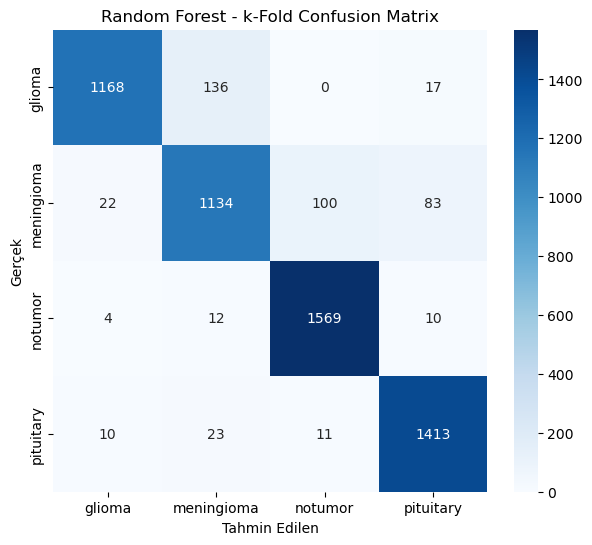

In [12]:
all_true = []
all_pred = []

for train_idx, val_idx in skf.split(X_train, y_train):

    X_train_k = X_train[train_idx]
    X_val_k   = X_train[val_idx]

    y_train_k = y_train[train_idx]
    y_val_k   = y_train[val_idx]

    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train_k, y_train_k)
    y_pred_k = rf.predict(X_val_k)

    all_true.extend(y_val_k)
    all_pred.extend(y_pred_k)

cm_rf_kfold = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_rf_kfold,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Random Forest - k-Fold Confusion Matrix")
plt.show()

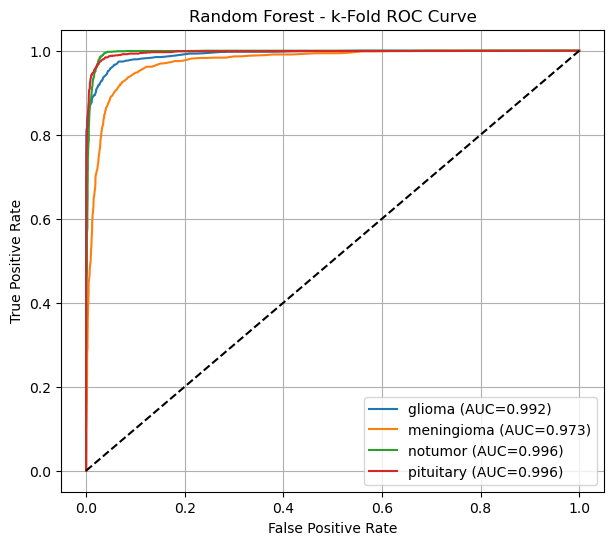

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_true = []
all_prob = []

for train_idx, val_idx in skf.split(X_train, y_train):

    X_train_k, X_val_k = X_train[train_idx], X_train[val_idx]
    y_train_k, y_val_k = y_train[train_idx], y_train[val_idx]

    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train_k, y_train_k)
    y_prob_k = rf.predict_proba(X_val_k)

    all_true.extend(y_val_k)
    all_prob.extend(y_prob_k)

all_true = np.array(all_true)
all_prob = np.array(all_prob)

# ROC ÇİZİMİ
plt.figure(figsize=(7,6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(all_true == i, all_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - k-Fold ROC Curve")
plt.legend()
plt.grid()
plt.show()

## AdaBoost Hold Out

In [8]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

In [9]:
ada.fit(X_train,y_train)

,estimator,None
,n_estimators,200
,learning_rate,0.5
,algorithm,'deprecated'
,random_state,42


In [11]:
y_pred_ada=ada.predict(X_test)
y_prob_ada=ada.predict_proba(X_test)

In [12]:
accuarcy_ada = accuracy_score(y_test,y_pred_ada)
print(accuarcy_ada)

0.7551487414187643


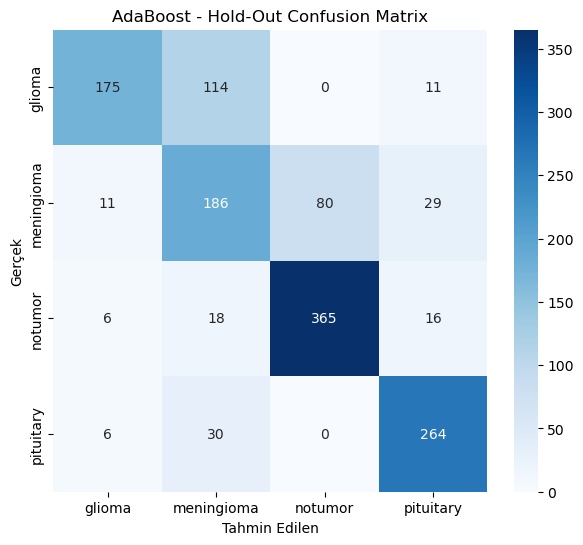

In [13]:
cm_ada=confusion_matrix(y_test,y_pred_ada)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_ada,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("AdaBoost - Hold-Out Confusion Matrix")
plt.show()

In [15]:
report = classification_report(
    y_test,
    y_pred_ada,
    target_names=labels,
    output_dict=True
)

specificity = {}

for i, label in enumerate(labels):
    TN = cm_ada.sum() - (cm_ada[i, :].sum() + cm_ada[:, i].sum() - cm_ada[i, i])
    FP = cm_ada[:, i].sum() - cm_ada[i, i]
    specificity[label] = TN / (TN + FP)

ada_table = pd.DataFrame({
    "precision":   [report[l]["precision"] for l in labels],
    "recall":      [report[l]["recall"] for l in labels],
    "f1-score":    [report[l]["f1-score"] for l in labels],
    "specificity": [specificity[l] for l in labels]
}, index=labels)

print("\nAdaBoost - Hold-Out Performans Tablosu")
print("-"*55)
print(ada_table.round(4))
print("\nGenel Doğruluk (Accuracy):", round(accuarcy_ada, 4))


AdaBoost - Hold-Out Performans Tablosu
-------------------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.8838  0.5833    0.7028       0.9773
meningioma     0.5345  0.6078    0.5688       0.8388
notumor        0.8202  0.9012    0.8588       0.9117
pituitary      0.8250  0.8800    0.8516       0.9446

Genel Doğruluk (Accuracy): 0.7551


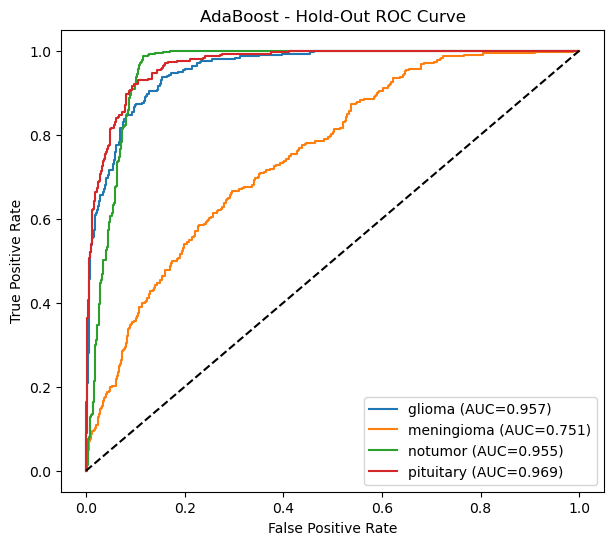

In [16]:
plt.figure(figsize=(7,6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob_ada[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AdaBoost - Hold-Out ROC Curve")
plt.legend()
plt.show()

## AdaBoost K-Fold

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

print("AdaBoost - k-Fold Sonuçları")
print("-"*45)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):

    X_train_k = X_train[train_idx]
    X_val_k   = X_train[val_idx]

    y_train_k = y_train[train_idx]
    y_val_k   = y_train[val_idx]

    ada = AdaBoostClassifier(
        n_estimators=200,
        learning_rate=0.5,
        random_state=42
    )

    ada.fit(X_train_k, y_train_k)
    y_pred_k = ada.predict(X_val_k)

    acc = accuracy_score(y_val_k, y_pred_k)
    fold_accuracies.append(acc)

    print(f"Fold {fold}: Accuracy = {acc:.4f}")

print("-"*45)
print(f"Ortalama Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Std Sapma: {np.std(fold_accuracies):.4f}")

AdaBoost - k-Fold Sonuçları
---------------------------------------------
Fold 1: Accuracy = 0.8206
Fold 2: Accuracy = 0.8014
Fold 3: Accuracy = 0.8179
Fold 4: Accuracy = 0.8100
Fold 5: Accuracy = 0.7942
---------------------------------------------
Ortalama Accuracy: 0.8088
Std Sapma: 0.0099


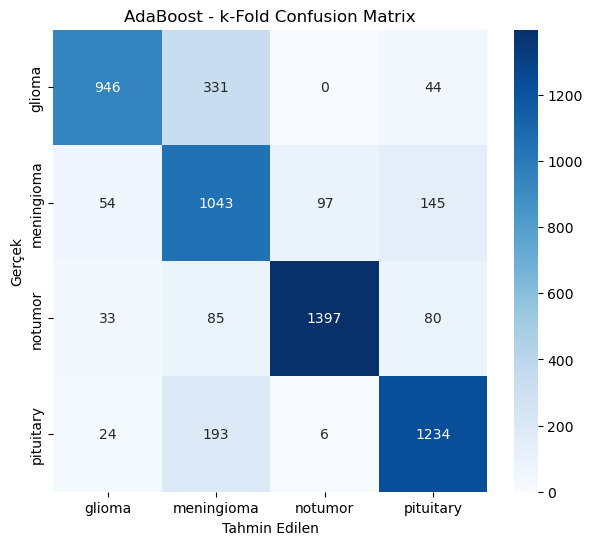

In [18]:
all_true = []
all_pred = []

for train_idx, val_idx in skf.split(X_train, y_train):

    X_train_k = X_train[train_idx]
    X_val_k   = X_train[val_idx]

    y_train_k = y_train[train_idx]
    y_val_k   = y_train[val_idx]

    ada = AdaBoostClassifier(
        n_estimators=200,
        learning_rate=0.5,
        random_state=42
    )

    ada.fit(X_train_k, y_train_k)
    y_pred_k = ada.predict(X_val_k)

    all_true.extend(y_val_k)
    all_pred.extend(y_pred_k)

cm_ada_kfold = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_ada_kfold,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("AdaBoost - k-Fold Confusion Matrix")
plt.show()

In [20]:
report = classification_report(
    all_true,
    all_pred,
    target_names=labels,
    output_dict=True
)

specificity = {}

for i, label in enumerate(labels):
    TN = cm_ada_kfold.sum() - (cm_ada_kfold[i, :].sum() + cm_ada_kfold[:, i].sum() - cm_ada_kfold[i, i])
    FP = cm_ada_kfold[:, i].sum() - cm_ada_kfold[i, i]
    specificity[label] = TN / (TN + FP)

ada_kfold_table = pd.DataFrame({
    "precision":   [report[l]["precision"] for l in labels],
    "recall":      [report[l]["recall"] for l in labels],
    "f1-score":    [report[l]["f1-score"] for l in labels],
    "specificity": [specificity[l] for l in labels]
}, index=labels)

print("\nAdaBoost - k-Fold Performans Tablosu")
print(f"Accuracy: {np.mean(fold_accuracies):.4f}")
print("-"*55)
print(ada_kfold_table.round(4))


AdaBoost - k-Fold Performans Tablosu
Accuracy: 0.8088
-------------------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.8950  0.7161    0.7956       0.9747
meningioma     0.6314  0.7789    0.6974       0.8607
notumor        0.9313  0.8759    0.9027       0.9750
pituitary      0.8210  0.8469    0.8338       0.9368


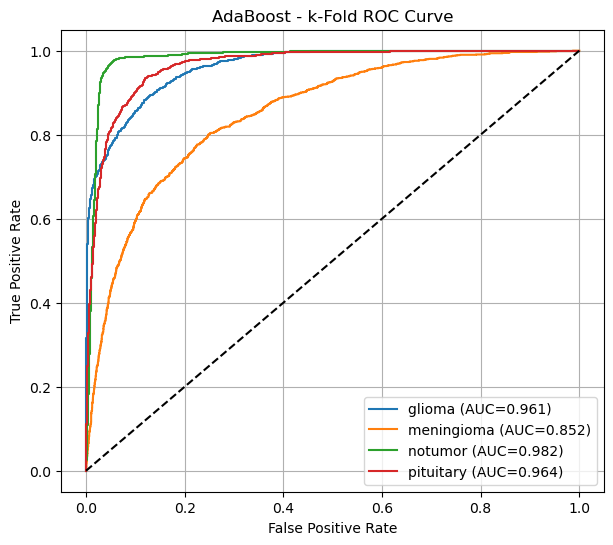

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_true = []
all_prob = []

for train_idx, val_idx in skf.split(X_train, y_train):

    X_train_k, X_val_k = X_train[train_idx], X_train[val_idx]
    y_train_k, y_val_k = y_train[train_idx], y_train[val_idx]

    ada = AdaBoostClassifier(
        n_estimators=200,
        learning_rate=0.5,
        random_state=42
    )

    ada.fit(X_train_k, y_train_k)
    y_prob_k = ada.predict_proba(X_val_k)

    all_true.extend(y_val_k)
    all_prob.extend(y_prob_k)

all_true = np.array(all_true)
all_prob = np.array(all_prob)

plt.figure(figsize=(7,6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(all_true == i, all_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AdaBoost - k-Fold ROC Curve")
plt.legend()
plt.grid()
plt.show()

## McNemar Test

In [20]:
np.save("rf_y_true.npy", y_test)
np.save("rf_y_pred.npy", y_pred_rf)

In [21]:
y_true_cnn = np.load("cnn_y_true.npy")
y_pred_cnn = np.load("cnn_y_pred.npy")
y_true_rf = np.load("rf_y_true.npy")

In [29]:

y_true_actual = np.load('cnn_y_true.npy')
y_pred_cnn = np.load('cnn_y_pred.npy')
print("CNN dosyaları başarıyla yüklendi.")


table = mcnemar_table(y_target=y_true_actual, 
                      y_model1=y_pred_cnn, 
                      y_model2=y_pred_rf)

print("\n--- McNemar Kontenjans Tablosu (CNN vs RF) ---")
print(table)


chi2, p = mcnemar(ary=table, corrected=True)
print(f"\np-değeri: {p:.4f}")

df_table = pd.DataFrame(table, 
                        index=['CNN Doğru', 'CNN Yanlış'], 
                        columns=['RF Doğru', 'RF Yanlış'])

print("--- Akademik McNemar Tablosu ---")
print(df_table)
print(f"\np-değeri: {p:.4f}")


CNN dosyaları başarıyla yüklendi.

--- McNemar Kontenjans Tablosu (CNN vs RF) ---
[[ 95 205]
 [244 767]]

p-değeri: 0.0729
Sonuç: Fark istatistiksel olarak anlamlı değildir.


---McNemar Tablosu ---
            RF Doğru  RF Yanlış
CNN Doğru         95        205
CNN Yanlış       244        767

p-değeri: 0.0729


Text(70.72222222222221, 0.5, 'EfficientNetB0 (CNN) Tahminleri')

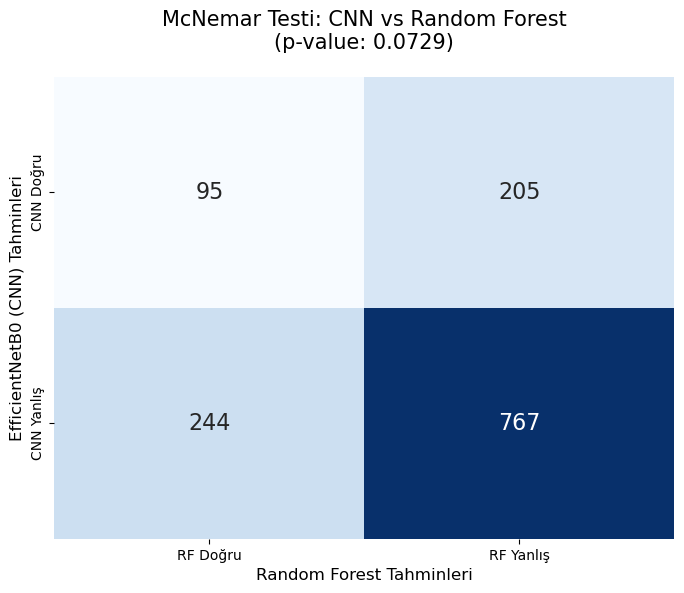

In [37]:
table = np.array([[95, 205], 
                  [244, 767]])

chi2, p = mcnemar(ary=table, corrected=True)


df_table = pd.DataFrame(table, 
                        index=['CNN Doğru', 'CNN Yanlış'], 
                        columns=['RF Doğru', 'RF Yanlış'])

print("---McNemar Tablosu ---")
print(df_table)
print(f"\np-değeri: {p:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(df_table, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title(f'McNemar Testi: CNN vs Random Forest\n(p-value: {p:.4f})', fontsize=15, pad=20)
plt.xlabel('Random Forest Tahminleri', fontsize=12)
plt.ylabel('EfficientNetB0 (CNN) Tahminleri', fontsize=12)

## McNemar K-Fold

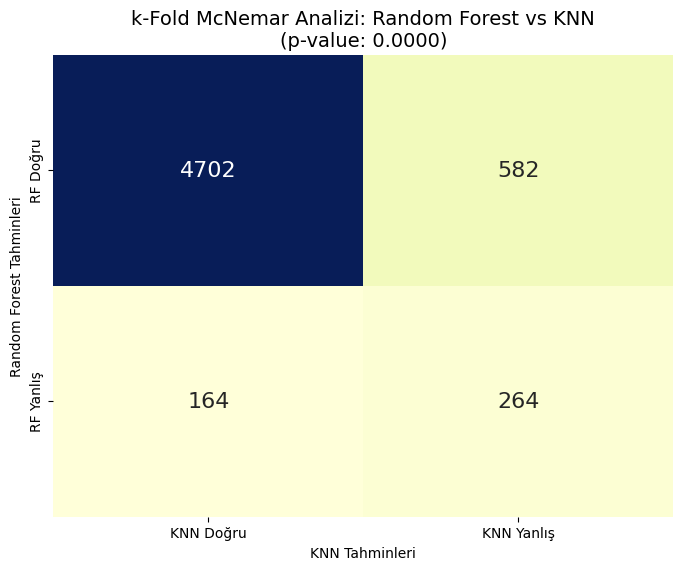

p-değeri: 0.0000


In [15]:
from mlxtend.evaluate import mcnemar_table, mcnemar


y_true_k = np.load('kfold_y_true.npy')
y_rf_k = np.load('kfold_y_pred_rf.npy')
y_knn_k = np.load('kfold_y_pred_knn.npy')


table_kfold = mcnemar_table(y_target=y_true_k, 
                            y_model1=y_rf_k, 
                            y_model2=y_knn_k)


chi2, p = mcnemar(ary=table_kfold, corrected=True)


df_kfold = pd.DataFrame(table_kfold, 
                        index=['RF Doğru', 'RF Yanlış'], 
                        columns=['KNN Doğru', 'KNN Yanlış'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_kfold, annot=True, fmt='d', cmap='YlGnBu', cbar=False, annot_kws={"size": 16})
plt.title(f'k-Fold McNemar Analizi: Random Forest vs KNN\n(p-value: {p:.4f})', fontsize=14)
plt.xlabel('KNN Tahminleri')
plt.ylabel('Random Forest Tahminleri')
plt.show()

print(f"p-değeri: {p:.4f}")